## Mini-Project 3: Making Plots

This first mega block of code does reads in the data and follows the steps to calibrate counts to magnitudes.

In [158]:
# import pandas for reading tabular data, numpy for math
# and matplotlib for plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# import my scripts for convenience
import error_calculator as ec

# read in the data from our various tables
b = pd.read_table("phot-B.ASC", sep=r'\s+')
i = pd.read_table("phot-I.ASC", sep=r'\s+')
r = pd.read_table("phot-R.ASC", sep=r'\s+')
v = pd.read_table("phot-V.ASC", sep=r'\s+')

# index of our special calibration star
idx = 3306

# get index to remove flags >= 4
keep_idx = b.loc[:, "FLAGS"] < 4

# photometry and error of our calibration star
# THIS ASSUMES WE FOLLOW BVRI order in the step below
cal_star = [(14.557, 0.004), (13.522, 0.003), (13.157, 0.002), (11.948, 0.002)]
filt_name = ['b', 'v', 'r', 'i']
filters = [b, v, r, i]
new = dict()

# do a few things simultaneously
# 0. drop all objects with a flag >= 4
# 1. convert to instrumental magnitudes
# 2. using the calibration star, determine a magnitude conversion factor
# 3. use conversion factor to get actual magnitudes for all stars
for name, data, cal in zip(filt_name, filters, cal_star):
    # drop rows with flag > 4
    data = data.loc[keep_idx, :]
    # read flux from data, convert to instrumental magnitude
    flux, flux_err = data.loc[:, 'FLUX_APER'], data.loc[:, "FLUXERR_APER"]
    mag, mag_err = ec.flux2mag(flux, flux_err)
    # add instrumental magnitude columns to the table for later use
    data.loc[:, "inst_mag"] = mag
    data.loc[:, "inst_mag_err"] = mag_err
    # get the magnitude of our calibration star
    inst_cal_mag = data.loc[idx, "inst_mag"]
    inst_cal_mag_err = data.loc[idx, "inst_mag_err"]
    # determine the conversion factor
    cal_mag, cal_mag_err = cal[0], cal[1]
    mag_convert = cal_mag - inst_cal_mag
    mag_convert_err = ec.err_add(cal_mag_err, inst_cal_mag_err)
    # now apply the conversion factor to create a new column
    data.loc[:, "mag"] = mag_convert + data.loc[:,'inst_mag']
    # calculate the error using
    data.loc[:, "mag_err"] = ec.err_add(data.loc[:, "inst_mag_err"], mag_convert_err)
    new[name] = data
    
# we need to convert r and i to R and I
new['r'].loc[:, "mag_R"] = new['r'].loc[:, "mag"]-0.2936*(new['r'].loc[:, 'mag']-new['i'].loc[:, 'mag'])-0.1439
new['i'].loc[:, "mag_I"] = new['r'].loc[:, "mag"]-1.2444*(new['r'].loc[:, "mag"]-new['i'].loc[:, 'mag'])-0.382

new['r'].loc[:, "mag_R_err"] = np.sqrt( ((1-0.2936)*new['r'].loc[:, 'mag_err'])**2 + (0.2936*new['i'].loc[:, 'mag_err'])**2)
new['i'].loc[:, "mag_I_err"] = np.sqrt( (.2444*new['r'].loc[:, "mag_err"])**2 + (1.2444*new['i'].loc[:, 'mag_err'])**2)

# before making plots, let's stop using this horrible pandas indexing
bmag = new['b'].loc[:, 'mag']
vmag = new['v'].loc[:, 'mag']
Imag = new['i'].loc[:, 'mag_I']
Rmag = new['r'].loc[:, 'mag_R']

# do this for errors as well
bmag_err = new['b'].loc[:, 'mag_err']
vmag_err = new['v'].loc[:, 'mag_err']
Imag_err = new['i'].loc[:, 'mag_I_err']
Rmag_err = new['r'].loc[:, 'mag_R_err']

# drop any NaN values; bitwise or so that we drop them for all images if they are NaN in one
nan_idx = np.isnan(bmag) | np.isnan(vmag) | np.isnan(Imag) | np.isnan(Rmag)
bmag = bmag[~nan_idx]
vmag = vmag[~nan_idx]
Imag = Imag[~nan_idx]
Rmag = Rmag[~nan_idx]

# drop corresponding error values
bmag_err = bmag_err[~nan_idx]
vmag_err = vmag_err[~nan_idx]
Imag_err = Imag_err[~nan_idx]
Rmag_err = Rmag_err[~nan_idx]

# useful quantities for later
BV = bmag-vmag
BV_err = ec.err_add(bmag_err, vmag_err)

/home/thomas/.conda/envs/nb/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_208969/1217228446.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "inst_mag"] = mag
/tmp/ipykernel_208969/1217228446.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "inst_mag_err"] = mag_err
/tmp/ipykernel_208969/1217228446.py:51: SettingWithCopyWarning: 
A value is tryin

(we can ignore those pandas warnings)

How many NaNs are we dropping here?

In [138]:
sum(nan_idx)

26

Since we have a few thousand targets, dropping 26 NaNs is reasonable.

## Making Plots

Here, I use gaussian kernel density estimates to make the plots prettier. There's a lot of overlap near the center otherwise, and it's hard to tell exactly how many points there are.

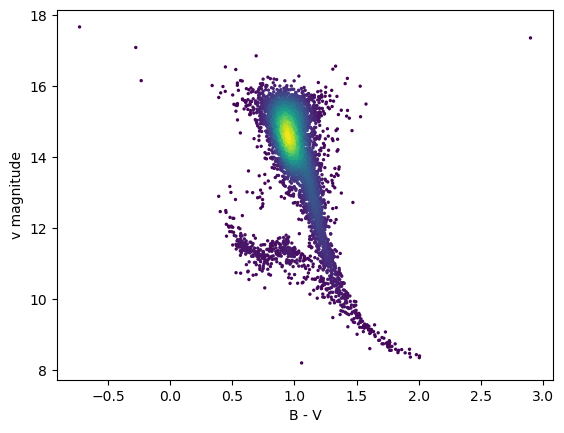

In [145]:
# now make some plots!!!
fig, ax = plt.subplots()

xy = np.vstack([BV,vmag])
z = gaussian_kde(xy)(xy)

ax.scatter(BV, vmag, c=z, s=2)

ax.set_xlabel("B - V")
ax.set_ylabel("v magnitude")

plt.show()

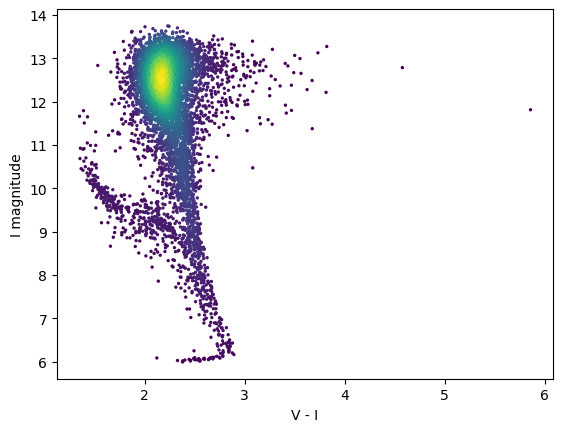

In [148]:
fig, ax = plt.subplots()

xy = np.stack([vmag-Imag, Imag])
z = gaussian_kde(xy)(xy)

ax.scatter(vmag-Imag, Imag, c=z, s=2)

ax.set_xlabel("V - I")
ax.set_ylabel("I magnitude")

plt.show()

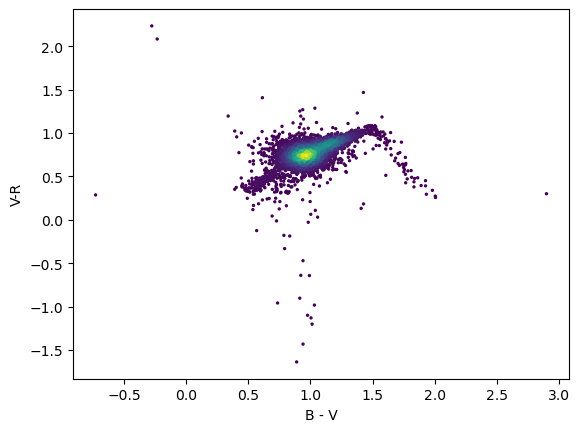

In [150]:
fig, ax = plt.subplots()

xy = np.stack([BV, vmag-Rmag])
z = gaussian_kde(xy)(xy)

ax.scatter(BV, vmag-Rmag, c=z, s=2)
ax.set_xlabel("B - V")
ax.set_ylabel("V-R")
plt.show()

## Plots with Errors

Let's include error bars in these plots.

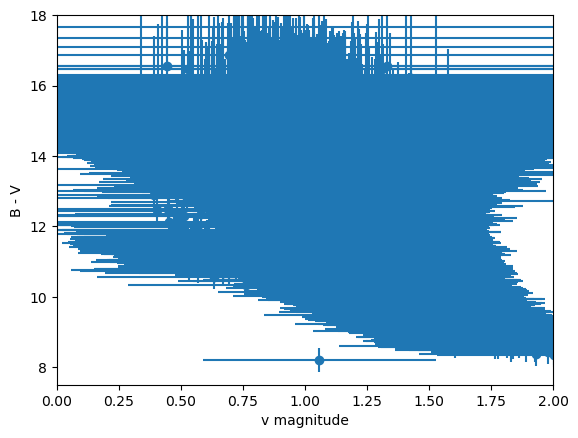

In [163]:
fig, ax = plt.subplots()
ax.errorbar(BV, vmag, fmt = 'o', xerr = BV_err, yerr = vmag_err)
ax.set_xlabel("v magnitude")
ax.set_ylabel("B - V")
ax.set_xlim([0, 2])
ax.set_ylim([7.5, 18])
plt.show()

Yikes. Even zoomed into match the limits of our first plot, there are so many error bars, you cannot see the plot itself.